## HMEQ_Data - Predict clients who default on their loan

Caso de Estudio: Riesgo Crediticio

Visión General del Dataset

El conjunto de datos utilizado contiene información de referencia y de rendimiento de préstamos para 5,960 préstamos. El objetivo (BAD) es una variable binaria que indica si un solicitante finalmente incurrió en incumplimiento o en grave mora en alguna entidad bancaria. Y por muestreo rápido. Este resultado adverso se produjo en 1.189 casos (20%) del total de la muestra.

Para cada aspirante a una tarjeta de crédito, se registraron 11 variables de entrada:

BAD: 1 = candidato con préstamo incumplido o con mora; 0 = candidato que paga su deuda y no tiene registro negativo

LOAN: Monto de solicitud de préstamo

MORTDUE: Monto adeudado de la hipoteca existente

VALUE: Valor actual del bien o propiedad

REASON: DebtCon = consolidación de la deuda; HomeImp = mejoras para el hogar

JOB: Categorias ocupacionales o profesionales

YOJ: Años es en su trabajo actual

DEROG: Número de informes derogados o cancelados importantes

DELINQ: Número de lineas de crédito morosas

CLAGE: Antiguedad de la linea de crédito más antigua en meses

NINQ:Número de consultas crediticas recientes

CLNO: Número de líneas de crédito

## Librerias 

In [ ]:
!pip install imbalanced-learn
!pip install joblib
!pip install pydotplus
!pip install pydot
!pip install graphviz
!pip install Pillow
!pip install Image

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools
from datetime import datetime 
import time
import sys
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, precision_recall_curve, f1_score, r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

     |████████████████████████████████| 7.9MB 7.1MB/s 
  Created wheel for Image: filename=image-1.5.33-py2.py3-none-any.whl size=19482 sha256=2cd7fb57dee0cb713a18f6c0873e437f6a0aebea4753b2e336f376bd8830e533
  Stored in directory: /root/.cache/pip/wheels/87/4c/60/d5904e69c837fcdea7e03ffa0c657f35ced7e398c6f3ca17cc
Successfully built Image


In [ ]:
#Lectura del archivo en Github
#Header: Identificación del primer registro como la cabecera de la base de datos
#Index: Identificador unico de la base de datos
#Visualización de 5 registros    
df0 = pd.read_excel(r'https://github.com/joatamayoav/Trabajo_Final_Analitica_Predictiva/blob/main/Modelo%202%20-%20Analistica%20Predictiva.xlsx?raw=true',
     header=1,
     index_col='ID'
    )
df0.head()


,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,BAD
ID,,,,,,,,,,,,,
1,1100,25860.0,39025.0,HomeImp,Other,10.5,0,0,94.366667,1,9,0.000000,1
2,1300,70053.0,68400.0,HomeImp,Other,7.0,0,2,121.833333,0,14,0.000000,1
3,1500,13500.0,16700.0,HomeImp,Other,4.0,0,0,149.466667,1,10,0.000000,1
4,1700,97800.0,112000.0,HomeImp,Office,3.0,0,0,93.333333,0,14,0.000000,0
5,1700,30548.0,40320.0,HomeImp,Other,9.0,0,0,101.466002,1,8,37.113614,1


In [ ]:
#Renombra variables en de mayúsculas a minúsculas
#Cambiar variable y de "default payment next month" a "Variable dependiente"
df0.rename(columns=lambda x: x.lower(), inplace=True)
df0.rename(columns={"bad":"Variable dependiente"}, inplace=True) 
df0.head()

,loan,mortdue,value,reason,job,yoj,derog,delinq,clage,ninq,clno,debtinc,Variable dependiente
ID,,,,,,,,,,,,,
1,1100,25860.0,39025.0,HomeImp,Other,10.5,0,0,94.366667,1,9,0.000000,1
2,1300,70053.0,68400.0,HomeImp,Other,7.0,0,2,121.833333,0,14,0.000000,1
3,1500,13500.0,16700.0,HomeImp,Other,4.0,0,0,149.466667,1,10,0.000000,1
4,1700,97800.0,112000.0,HomeImp,Office,3.0,0,0,93.333333,0,14,0.000000,0
5,1700,30548.0,40320.0,HomeImp,Other,9.0,0,0,101.466002,1,8,37.113614,1


In [ ]:
# Se crea copia del Dataframe original para no dañarlo
df = df0.copy()
df.head()

,loan,mortdue,value,reason,job,yoj,derog,delinq,clage,ninq,clno,debtinc,Variable dependiente
ID,,,,,,,,,,,,,
1,1100,25860.0,39025.0,HomeImp,Other,10.5,0,0,94.366667,1,9,0.000000,1
2,1300,70053.0,68400.0,HomeImp,Other,7.0,0,2,121.833333,0,14,0.000000,1
3,1500,13500.0,16700.0,HomeImp,Other,4.0,0,0,149.466667,1,10,0.000000,1
4,1700,97800.0,112000.0,HomeImp,Office,3.0,0,0,93.333333,0,14,0.000000,0
5,1700,30548.0,40320.0,HomeImp,Other,9.0,0,0,101.466002,1,8,37.113614,1


## Variables Dummys 

Variable ficticia para explicar valores cualitativos en un modelo de regresión.

In [ ]:
# Se construye un codificador para transformar
# los strings a enteros (similar a factores en R)
#
# Se aplica el codificador a las columnas
# del dataset
#

from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

columns = [
 'reason'          
,'job'           
]
for column in columns:
    df[column] = enc.fit_transform(df[column].astype(str))


df.head()


,loan,mortdue,value,reason,job,yoj,derog,delinq,clage,ninq,clno,debtinc,Variable dependiente
ID,,,,,,,,,,,,,
1,1100,25860.0,39025.0,1,2,10.5,0,0,94.366667,1,9,0.000000,1
2,1300,70053.0,68400.0,1,2,7.0,0,2,121.833333,0,14,0.000000,1
3,1500,13500.0,16700.0,1,2,4.0,0,0,149.466667,1,10,0.000000,1
4,1700,97800.0,112000.0,1,1,3.0,0,0,93.333333,0,14,0.000000,0
5,1700,30548.0,40320.0,1,2,9.0,0,0,101.466002,1,8,37.113614,1


## Análisis Descriptivo

In [ ]:
#dtypes: Visualizar variables y tipo de variables de la data
#df.shape: Cuantas variables y registros hay en la data
#Estatidisticas básicas de la data
print(df.dtypes)
print(df.shape)
df.describe()

loan                      int64
mortdue                 float64
value                   float64
reason                    int64
job                       int64
yoj                     float64
derog                     int64
delinq                    int64
clage                   float64
ninq                      int64
clno                      int64
debtinc                 float64
Variable dependiente      int64
dtype: object
(5449, 13)


,loan,mortdue,value,reason,job,yoj,derog,delinq,clage,ninq,clno,debtinc,Variable dependiente
count,5449.000000,5449.000000,5449.000000,5449.000000,5449.000000,5449.000000,5449.000000,5449.000000,5449.000000,5449.000000,5449.000000,5449.000000,5449.000000
mean,18729.253074,68816.596364,102538.714726,0.310883,1.933566,8.242742,0.213801,0.390714,175.313496,1.122958,21.161498,27.121500,0.191044
std,11001.492165,47173.102628,58337.548293,0.462897,1.142391,7.565077,0.766632,1.040231,89.834999,1.703177,10.353373,15.614455,0.393160
min,1100.000000,0.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11200.000000,41105.000000,66345.000000,0.000000,1.000000,2.000000,0.000000,0.000000,111.206513,0.000000,14.000000,21.621195,0.000000
50%,16500.000000,62506.000000,89848.000000,0.000000,2.000000,6.000000,0.000000,0.000000,170.700507,1.000000,20.000000,32.571867,0.000000
75%,23500.000000,89000.000000,120087.000000,1.000000,3.000000,12.000000,0.000000,0.000000,229.986998,2.000000,26.000000,38.195027,0.000000
max,89900.000000,399412.000000,855909.000000,1.000000,5.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,65.000000,203.312149,1.000000


## Análisis Exploratorio

In [ ]:
# Identificación de nulos por variable
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Variable dependiente,debtinc,clno,ninq,clage,delinq,derog,yoj,job,reason,value,mortdue,loan
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


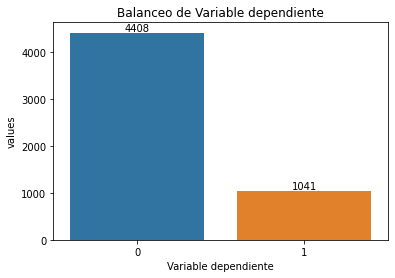

In [ ]:
# Creamos dataframe Variable dependiente se le asigna a df1
# Dimensiones del plot (6,4)
# Asignamos titulo
# Definición de colores}
# Se asigna la variables del gráfico x = Variable dependiente y y = conteo 
#
temp = df["Variable dependiente"].value_counts()
df1 = pd.DataFrame({'Variable dependiente': temp.index,'values': temp.values})
plt.figure(figsize = (6,4))
plt.title('Balanceo de Variable dependiente')
sns.set_color_codes("pastel")
graph = sns.barplot(x = 'Variable dependiente', y="values", data=df1)
for p in graph.patches:
        graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black',
                    xytext = (0, 0), 
                    textcoords = 'offset points'
                    )
locs, labels = plt.xticks()
plt.show()

## Modelación

###  Definición Metricas del Modelo

In [ ]:
# Definición del dataFrame de metricas
metrics = pd.DataFrame(index=['accuracy', 'f1_score', 'precision', 'recall', 'roc_auc_score', 'Tiempo de ejecución'],
                       columns=['BernoulliNB', 'GaussianNB', 'LogisticRegresion', 'kNN', 'DecisionTree', 'AdaBoost', 'RandomForest', 'GradientBoosting', 'RedesNeuronales' , 'SVMs'])
metrics

,BernoulliNB,GaussianNB,LogisticRegresion,kNN,DecisionTree,AdaBoost,RandomForest,GradientBoosting,RedesNeuronales,SVMs
accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f1_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
precision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
roc_auc_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tiempo de ejecución,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###  Definición Gráfica del Modelo

In [ ]:
# Creación de la matriz de confusión
# Se define la función "plot_confusion_matrix" se le asignan variables y parametros a imprimir
# La primera parte del codigo que se identifica con las siglas plt es para configuración de variables y aspecto de grafico 
# Por ejemplo: plt.imshow: define el grado de difuminasión del grafico de confusión
# En el for se hace la identificación de positivos, de negativos, falsos positivos y falsos negativos y se asigna colores para dichas variables
# Se condigura el gráfico conforme a x y y label

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greys):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[1])
    plt.xticks(tick_marks, rotation=0)
    ax = plt.gca()
    ax.set_xticklabels((ax.get_xticks()+0).astype(str))
    plt.yticks(tick_marks)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.0f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

### Conjuntos de entrenamiento y prueba 

In [ ]:
# Se define la variable Dependientes
# Elimina variable dependiente para entrenar
# Se aplica el RobustScaler para transformar las variables del modelo y hacer el fit
# Se define el proporción de el tamaño del datatest y numero minimo de iteraciones y la variable dependiente del Modelo 
target = 'Variable dependiente'
X = df.drop('Variable dependiente', axis = 1)
robust_scaler = RobustScaler()
X = robust_scaler.fit_transform(X)
Y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=100, stratify=Y)

### NB 

In [ ]:
# Se importa la libreria de modelo correspondiente
from sklearn.naive_bayes import BernoulliNB


#
# Se crean los parametros correspondientes al modelo, esto con el objetivo de optimizarlos por medio de la librería GridSearchCV
parameters = [{'alpha':np.linspace(0.0,1,5),'binarize':np.linspace(0.0,1,5),'fit_prior': ["True","False"]}]
# Se ejecuta la librería GridSearchCV
gnb = GridSearchCV(
    BernoulliNB(),
    parameters,
    cv=4
)
# Entrenamiento del modelo y selección de la combinación óptima de parámetros
gnb.fit(X_train, y_train)
y_pred_test = gnb.predict(X_test)
# Evaluación para matriz de confusión
y_test = np.asarray(y_test)
y_pred_test = np.asarray(y_pred_test)
# Calculo del tiempo en ejecución y definición de metricas
start_time = time.time()
metrics.loc['accuracy','BernoulliNB'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['f1_score','BernoulliNB'] = f1_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','BernoulliNB'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','BernoulliNB'] = recall_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['roc_auc_score','BernoulliNB'] = roc_auc_score(y_pred_test, y_test)
metrics.loc['Tiempo de ejecución','BernoulliNB'] = (time.time() - start_time)

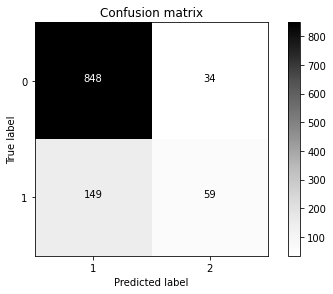

In [ ]:
#Reporte de Matriz de Confusión Modelo BernoulliNB
CM_BernoulliNB = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
plot = (plot_confusion_matrix(CM_BernoulliNB))

In [ ]:
# Se importa la libreria de modelo correspondiente
from sklearn.naive_bayes import GaussianNB

# Se crean los parametros correspondientes al modelo, esto con el objetivo de optimizarlos por medio de la librería GridSearchCV
parameters = [{'var_smoothing':np.logspace(0,-9, num=100)}]

# Se ejecuta la librería GridSearchCV, cv hace referencia al metodo de validación cruzada en este caso K-Folds=4 divide los datos 
# en 4 de secciones de prueba los cuales no se mezclan de forma predeterminada
gaussian = GridSearchCV(
    GaussianNB(),
    parameters,
    cv=4
)
# Entrenamiento del modelo y selección de la combinación óptima de parámetros
gaussian.fit(X_train, y_train)
y_pred_test = gnb.predict(X_test)
# Evaluación para matriz de confusión
y_test = np.asarray(y_test)
y_pred_test = np.asarray(y_pred_test)
# Calculo del tiempo en ejecución y definición de metricas
start_time = time.time()
metrics.loc['accuracy','GaussianNB'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['f1_score','GaussianNB'] = f1_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','GaussianNB'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','GaussianNB'] = recall_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['roc_auc_score','GaussianNB'] = roc_auc_score(y_pred_test, y_test)
metrics.loc['Tiempo de ejecución','GaussianNB'] = (time.time() - start_time)

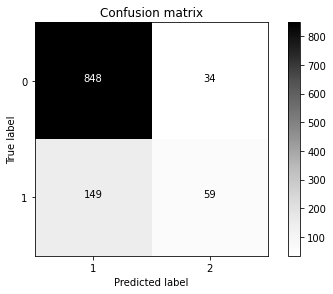

In [ ]:
#Reporte de Matriz de Confusión Modelo GaussianNB
CM_GaussianNB = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
plot = (plot_confusion_matrix(CM_GaussianNB))

### Regresión Logística

In [ ]:
# Se importa la libreria de modelo correspondiente
from sklearn.linear_model import LogisticRegression

# Se crean los parametros correspondientes al modelo, esto con el objetivo de optimizarlos por medio de la librería GridSearchCV
parameters = [{'penalty': ["none","l1", "l2", "elasticnet"],
               'C': [0.0], 
               'solver': [ "lbfgs", "sag", "saga"],
               'class_weight': ['None', 'dict', 'balanced'],
               'random_state': [123],
               'warm_start': ["True"],
               'n_jobs': [-1]}]

# Se ejecuta la librería GridSearchCV
logisticRegression = GridSearchCV(
    LogisticRegression(),
    parameters,
    cv = 4
)

# Entrenamiento del modelo y selección de la combinación óptima de parámetros
logisticRegression.fit(X_train, y_train)
y_pred_test = logisticRegression.predict(X_test)
#
# Evaluación
#
y_test = np.asarray(y_test)
y_pred_test = np.asarray(y_pred_test)

# Calculo del tiempo en ejecución y definición de metricas
start_time = time.time()
metrics.loc['accuracy','LogisticRegresion'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['f1_score','LogisticRegresion'] = f1_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','LogisticRegresion'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','LogisticRegresion'] = recall_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['roc_auc_score','LogisticRegresion'] = roc_auc_score(y_pred_test, y_test)
metrics.loc['Tiempo de ejecución','LogisticRegresion'] = (time.time() - start_time)

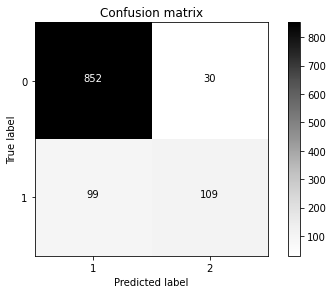

In [ ]:
#Reporte de Matriz de Confusión Modelo LogisticRegresion
CM_LogisticRegresion = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
plot = (plot_confusion_matrix(CM_LogisticRegresion))

### kNN

In [ ]:
# Se importa la libreria de modelo correspondiente
from sklearn.neighbors import KNeighborsClassifier

#
# Se crean los parametros correspondientes al modelo, esto con el objetivo de optimizarlos por medio de la librería GridSearchCV
parameters = [{'n_neighbors':[9,10,11],
               'weights': ["uniform","distance"],
               'n_jobs': [-1]}]

# Se ejecuta la librería GridSearchCV
knn = GridSearchCV(
    KNeighborsClassifier(),
    parameters,
    cv=4
)

# Entrenamiento del modelo y selección de la combinación óptima de parámetros
knn.fit(X_train, y_train)
y_pred_test = knn.predict(X_test)

# Evaluación para matriz de confusión
y_test = np.asarray(y_test)
y_pred_test = np.asarray(y_pred_test)


# Calculo del tiempo en ejecución y definición de metricas
start_time = time.time()
metrics.loc['accuracy','kNN'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['f1_score','kNN'] = f1_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','kNN'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','kNN'] = recall_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['roc_auc_score','kNN'] = roc_auc_score(y_pred_test, y_test)
metrics.loc['Tiempo de ejecución','kNN'] = (time.time() - start_time)

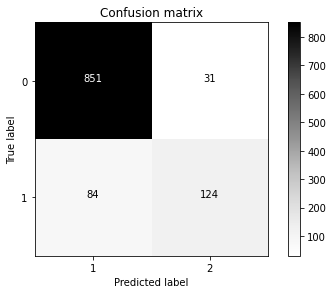

In [ ]:
#Reporte de Matriz de Confusión Modelo kNN
CM_kNN = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
plot = (plot_confusion_matrix(CM_kNN))

###DecisionTreeClassifier

In [ ]:
# Se importa la libreria de modelo correspondiente
from sklearn.tree import DecisionTreeClassifier

# Se crean los parametros correspondientes al modelo, esto con el objetivo de optimizarlos por medio de la librería GridSearchCV
parameters = [{'max_depth': np.arange(3, 10),
             'criterion' : ['gini'],
             'max_leaf_nodes': [5,10,20,100],
             'min_samples_split': [2, 5, 10, 20]}]


# # Se ejecuta la librería GridSearchCV
decisiontree = GridSearchCV(
    DecisionTreeClassifier(),
    parameters,
    cv=4
)

# Entrenamiento del modelo y selección de la combinación óptima de parámetros
decisiontree.fit(X_train, y_train)
y_pred_test = decisiontree.predict(X_test)

# Evaluación para matriz de confusión
y_test = np.asarray(y_test)
y_pred_test = np.asarray(y_pred_test)

# Calculo del tiempo en ejecución y definición de metricas
start_time = time.time()
metrics.loc['accuracy','DecisionTree'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['f1_score','DecisionTree'] = f1_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','DecisionTree'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','DecisionTree'] = recall_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['roc_auc_score','DecisionTree'] = roc_auc_score(y_pred_test, y_test)
metrics.loc['Tiempo de ejecución','DecisionTree'] = (time.time() - start_time)

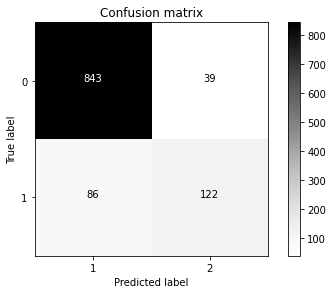

In [ ]:
#Reporte de Matriz de Confusión Modelo DecisionTree
CM_DecisionTree = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
plot = (plot_confusion_matrix(CM_DecisionTree))

### Ensambles de Modelos

In [ ]:
# Se importa la libreria de modelo correspondiente
from sklearn.ensemble import AdaBoostClassifier

# Se crean los parametros correspondientes al modelo, esto con el objetivo de optimizarlos por medio de la librería GridSearchCV
parameters = [{'n_estimators':[50,60,70,80]}]

# Se ejecuta la librería GridSearchCV

AdaBoost =  GridSearchCV(
    AdaBoostClassifier(),
    parameters,
    cv=4
)

# AdaBoostClassifier(n_estimators=10)

# Entrenamiento del modelo y selección de la combinación óptima de parámetros
AdaBoost.fit(X_train, y_train)
y_pred_test = AdaBoost.predict(X_test)

# Evaluación para matriz de confusión
y_test = np.asarray(y_test)
y_pred_test = np.asarray(y_pred_test)

# Calculo del tiempo en ejecución y definición de metricas
start_time = time.time()
metrics.loc['accuracy','AdaBoost'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['f1_score','AdaBoost'] = f1_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','AdaBoost'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','AdaBoost'] = recall_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['roc_auc_score','AdaBoost'] = roc_auc_score(y_pred_test, y_test)
metrics.loc['Tiempo de ejecución','AdaBoost'] = (time.time() - start_time)

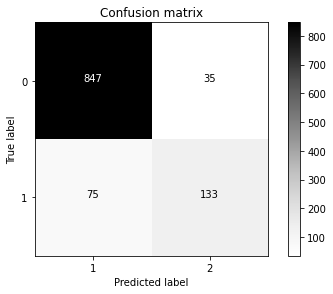

In [ ]:
#Reporte de Matriz de Confusión Modelo AdaBoost
CM_AdaBoost = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
plot = (plot_confusion_matrix(CM_AdaBoost))

In [ ]:
# Se importa la libreria de modelo correspondiente
from sklearn.ensemble import RandomForestClassifier

# Se crean los parametros correspondientes al modelo, esto con el objetivo de optimizarlos por medio de la librería GridSearchCV
parameters = [{'max_depth': [6,7,8],
             'criterion' : ['gini'],
             'n_estimators':[120,140]}]


# Se ejecuta la librería GridSearchCV
RandomForest = GridSearchCV(
    RandomForestClassifier(),
    parameters,
    cv=4
)

# Entrenamiento del modelo y selección de la combinación óptima de parámetros
RandomForest.fit(X_train, y_train)
y_pred_test = RandomForest.predict(X_test)

# Evaluación para matriz de confusión
y_test = np.asarray(y_test)
y_pred_test = np.asarray(y_pred_test)

# Calculo del tiempo en ejecución y definición de metricas
start_time = time.time()
metrics.loc['accuracy','RandomForest'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['f1_score','RandomForest'] = f1_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','RandomForest'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','RandomForest'] = recall_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['roc_auc_score','RandomForest'] = roc_auc_score(y_pred_test, y_test)
metrics.loc['Tiempo de ejecución','RandomForest'] = (time.time() - start_time)

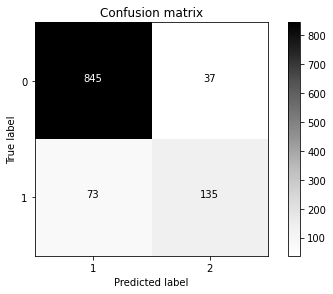

In [ ]:
#Reporte de Matriz de Confusión Modelo RandomForest
CM_RandomForest = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
plot = (plot_confusion_matrix(CM_RandomForest))

In [ ]:
# Se importa la libreria de modelo correspondiente
from sklearn.ensemble import GradientBoostingClassifier

# Se crean los parametros correspondientes al modelo, esto con el objetivo de optimizarlos por medio de la librería GridSearchCV
parameters = [{}]

# Se ejecuta la librería GridSearchCV
GradientBoosting = GridSearchCV(
    GradientBoostingClassifier(),
    parameters,
    cv=4
)

# Entrenamiento del modelo y selección de la combinación óptima de parámetros
GradientBoosting.fit(X_train, y_train)
y_pred_test = GradientBoosting.predict(X_test)

# Evaluación para matriz de confusión
y_test = np.asarray(y_test)
y_pred_test = np.asarray(y_pred_test)

# Calculo del tiempo en ejecución y definición de metricas
start_time = time.time()
metrics.loc['accuracy','GradientBoosting'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['f1_score','GradientBoosting'] = f1_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','GradientBoosting'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','GradientBoosting'] = recall_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['roc_auc_score','GradientBoosting'] = roc_auc_score(y_pred_test, y_test)
metrics.loc['Tiempo de ejecución','GradientBoosting'] = (time.time() - start_time)

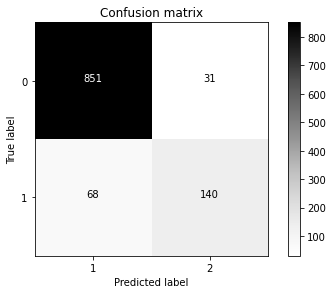

In [ ]:
#Reporte de Matriz de Confusión Modelo GradientBoosting
CM_GradientBoosting = confusion_matrix(y_pred=y_pred_test, y_true=y_test)


plot = (plot_confusion_matrix(CM_GradientBoosting))

### Redes Neuronales

In [ ]:
# Se importa la libreria de modelo correspondiente
from sklearn.neural_network import MLPClassifier

# # Se crean los parametros correspondientes al modelo, esto con el objetivo de optimizarlos por medio de la librería GridSearchCV
parameters = [{'hidden_layer_sizes': [(10,)],
               'activation': ['logistic'],
               'solver': ['sgd'],
               'alpha': [0.0],
               'verbose': [False],
               'shuffle': [True],
               'tol': [1e-4],
               'max_iter': [20000],
               'momentum': [0.9],
               'learning_rate': ['adaptive'],
               'learning_rate_init': [0.1],
               'nesterovs_momentum': [False]}]

# Se ejecuta la librería GridSearchCV
RedesNeuronales = GridSearchCV(
    MLPClassifier(),
    parameters,
    cv=4
)

#
# El parámetro hidden_layer_sizes recibe una tupla que
# indica la cantidad de neuronas de cada capa oculta. En
# el caso presentado, el valor (6,) indica que hay una sola
# capa oculta con 6 neuronas que usan la función sigmoidea.
# El parámetro solver = 'sgd' indica que se usará el
# algoritmo de gradiente descendente estocástico para entrenar
# la red neuronal.
#

# Entrenamiento del modelo y selección de la combinación óptima de parámetros
RedesNeuronales.fit(X_train, y_train)
y_pred_test = RedesNeuronales.predict(X_test)

# Evaluación para matriz de confusión
y_test = np.asarray(y_test)
y_pred_test = np.asarray(y_pred_test)

# Calculo del tiempo en ejecución y definición de metricas
start_time = time.time()
metrics.loc['accuracy','RedesNeuronales'] = accuracy_score(y_true=y_test, y_pred=y_pred_test)
metrics.loc['f1_score','RedesNeuronales'] = f1_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','RedesNeuronales'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','RedesNeuronales'] = recall_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['roc_auc_score','RedesNeuronales'] = roc_auc_score(y_pred_test, y_test)
metrics.loc['Tiempo de ejecución','RedesNeuronales'] = (time.time() - start_time)

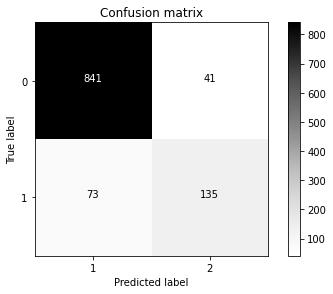

In [ ]:
#Reporte de Matriz de Confusión Modelo RedesNeuronales
CM_RedesNeuronales = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
plot = (plot_confusion_matrix(CM_RedesNeuronales))

### SVC

In [ ]:
# Se importa la libreria de modelo correspondiente
from sklearn.svm import SVC

# Se crean los parametros correspondientes al modelo, esto con el objetivo de optimizarlos por medio de la librería GridSearchCV
parameters = [{'C':np.linspace(0.0,1,3),
               'kernel': ["sigmoid"],
               'gamma': ["scale"]}]
# Se ejecuta la librería GridSearchCV

svc = GridSearchCV(
    SVC(),
    parameters,
    cv=4
)

# Entrenamiento del modelo y selección de la combinación óptima de parámetros
svc.fit(X_train, y_train)
y_pred_test = svc.predict(X_test)

# Evaluación para matriz de confusión
y_test = np.asarray(y_test)
y_pred_test = np.asarray(y_pred_test)

# Calculo del tiempo en ejecución y definición de metricas
start_time = time.time()
metrics.loc['accuracy','SVMs'] = accuracy_score(y_true=y_test, y_pred=y_pred_test)
metrics.loc['f1_score','SVMs'] = f1_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','SVMs'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','SVMs'] = recall_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['roc_auc_score','SVMs'] = roc_auc_score(y_pred_test, y_test)
metrics.loc['Tiempo de ejecución','SVMs'] = (time.time() - start_time)

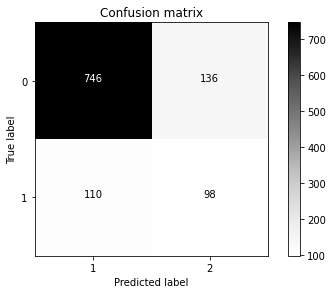

In [ ]:
#Reporte de Matriz de Confusión Modelo SVM
CM_SVM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
plot = (plot_confusion_matrix(CM_SVM))

## Resultado de Modelos

In [ ]:
metrics

,BernoulliNB,GaussianNB,LogisticRegresion,kNN,DecisionTree,AdaBoost,RandomForest,GradientBoosting,RedesNeuronales,SVMs
accuracy,0.83211,0.83211,0.881651,0.894495,0.885321,0.899083,0.899083,0.909174,0.895413,0.774312
f1_score,0.392027,0.392027,0.628242,0.683196,0.661247,0.707447,0.710526,0.738786,0.703125,0.443439
precision,0.634409,0.634409,0.784173,0.8,0.757764,0.791667,0.784884,0.818713,0.767045,0.418803
recall,0.283654,0.283654,0.524038,0.596154,0.586538,0.639423,0.649038,0.673077,0.649038,0.471154
roc_auc_score,0.74248,0.74248,0.840036,0.85508,0.832596,0.855161,0.852682,0.87236,0.843588,0.645149
Tiempo de ejecución,0.00591207,0.00553966,0.0129368,0.00636172,0.00588441,0.00610566,0.0056591,0.00592899,0.00791144,0.00612092


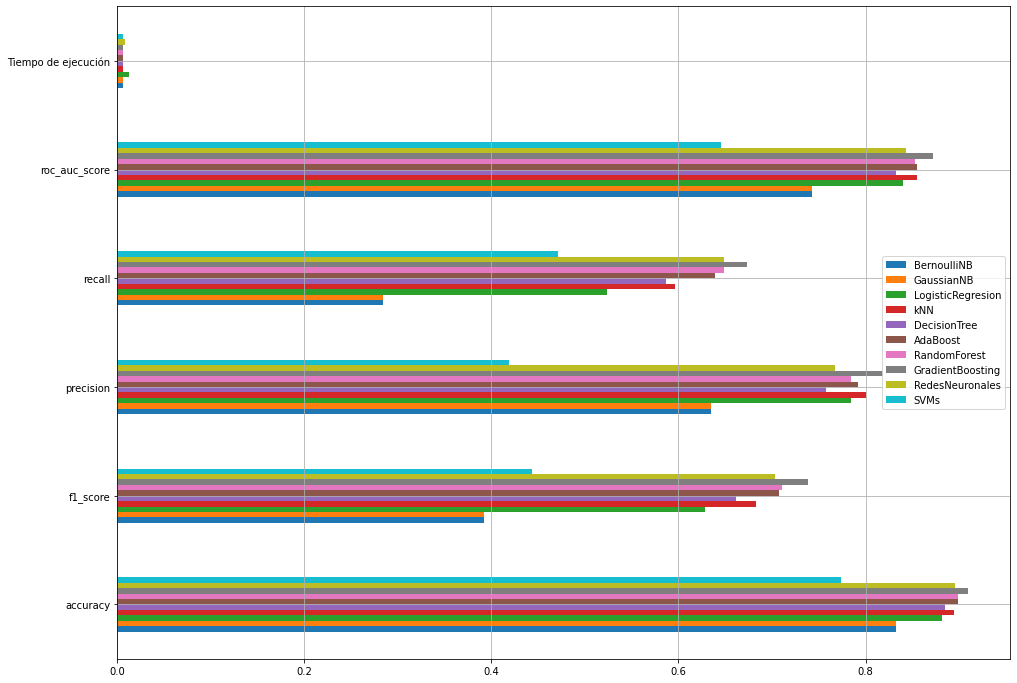

In [ ]:
fig, ax = plt.subplots(figsize = (16, 12))
metrics.plot(kind='barh', ax=ax)
ax.grid();

# Prueba Inputs
# Inputs

In [ ]:
# Prueba de todos los Modelos con un quick_inputs 

Xnew = [[20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0]]
ynew_BernoulliNB = gnb.predict(Xnew)
ynew_GaussianNB = gaussian.predict(Xnew)
ynew_LogisticRegresion = logisticRegression.predict(Xnew)
ynew_kNN = knn.predict(Xnew)
ynew_DecisionTree = decisiontree.predict(Xnew)
ynew_AdaBoost = AdaBoost.predict(Xnew)
ynew_RandomForest = RandomForest.predict(Xnew)
ynew_GradientBoosting = GradientBoosting.predict(Xnew)
ynew_RedesNeuronales = RedesNeuronales.predict(Xnew)
ynew_SVMs = svc.predict(Xnew)

print("Variables = %s, Predicted = %s" % (Xnew[0], ynew_BernoulliNB[0]))
print("Variables = %s, Predicted = %s" % (Xnew[0], ynew_GaussianNB[0]))
print("Variables = %s, Predicted = %s" % (Xnew[0], ynew_LogisticRegresion[0]))
print("Variables = %s, Predicted = %s" % (Xnew[0], ynew_DecisionTree[0]))
print("Variables = %s, Predicted = %s" % (Xnew[0], ynew_AdaBoost[0]))
print("Variables = %s, Predicted = %s" % (Xnew[0], ynew_RandomForest[0]))
print("Variables = %s, Predicted = %s" % (Xnew[0], ynew_GradientBoosting[0]))
print("Variables = %s, Predicted = %s" % (Xnew[0], ynew_RedesNeuronales[0]))
print("Variables = %s, Predicted = %s" % (Xnew[0], ynew_SVMs[0]))

ValueError: ignored